# CSE4020 Final Project

**Names: Max Miller, Steven Chase, Rahul Bala Vedha Rajkumar** | Topic: Final Project

## Question 1 (a)

Create a database named db_airways. Create tables in your database by reducing the following ER
diagram to tables and issuing the necessary DDL statements on your database. Please take into consideration
the sample data provided in the CSV files on Canvas and shown as a picture overleaf when reducing your tables.

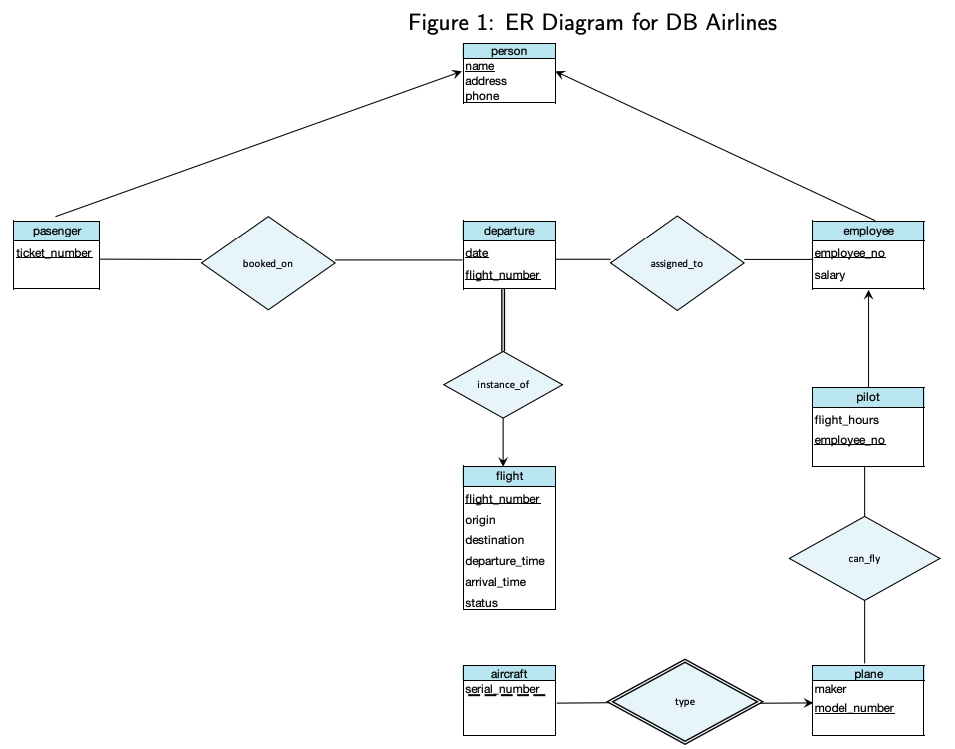

First, we connected to the AWS RDS

In [1]:
import mysql.connector

In [2]:
from IPython.display import display, Markdown

In [3]:
connection = mysql.connector.connect (
database='db_airways',
user='admin',
password='oreois15',
host='bankdb.cxhkqfq4ih8i.us-east-1.rds.amazonaws.com'
)
cursor = connection.cursor()

Next, we created the DDL file based on the ER diagram

In [4]:
def batch_execute_ddl():
    tables = ["person", 
              "passenger", 
              "employee", 
              "departure", 
              "assigned_to",
              "booked_on",
              "flight",
              "instance_of"
              "pilot", 
              "plane", 
              "aircraft", 
              "can_fly"]
    file = open('/Users/maxmiller/Code/CSE4020/CSE4020_Final_Project/db_airways.sql')
    sql = file.read()
    
    # multi allows us to execute multiple ddl statements
    for result in cursor.execute(sql, multi=True):
        pass

    for table in tables:
        cursor.execute(f"SHOW CREATE TABLE {table}")
        result = cursor.fetchall()
        # EXTRA CREDIT
        for row in result:
            table_name = row[0]
            create_statement = row[1]
            display(Markdown(f"```sql\n{create_statement}\n```"))

In [5]:
batch_execute_ddl()

```sql
CREATE TABLE `person` (
  `name` varchar(50) NOT NULL,
  `address` varchar(100) DEFAULT NULL,
  `phone` varchar(15) DEFAULT NULL,
  PRIMARY KEY (`name`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `employee` (
  `employee_no` int NOT NULL,
  `name` varchar(20) DEFAULT NULL,
  `salary` int DEFAULT NULL,
  PRIMARY KEY (`employee_no`),
  KEY `name` (`name`),
  CONSTRAINT `employee_ibfk_1` FOREIGN KEY (`name`) REFERENCES `person` (`name`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `departure` (
  `departure_date` date NOT NULL,
  `flight_number` int NOT NULL,
  PRIMARY KEY (`departure_date`,`flight_number`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `flight` (
  `flight_number` int NOT NULL,
  `origin` varchar(5) DEFAULT NULL,
  `destination` varchar(5) DEFAULT NULL,
  `departure_time` time DEFAULT NULL,
  `arrival_time` time DEFAULT NULL,
  `status` varchar(10) DEFAULT NULL,
  PRIMARY KEY (`flight_number`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `pilot` (
  `employee_no` int DEFAULT NULL,
  `flight_Hours` int DEFAULT NULL,
  KEY `employee_no` (`employee_no`),
  CONSTRAINT `pilot_ibfk_1` FOREIGN KEY (`employee_no`) REFERENCES `employee` (`employee_no`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `plane` (
  `maker` varchar(10) DEFAULT NULL,
  `model_no` varchar(10) NOT NULL,
  PRIMARY KEY (`model_no`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `aircraft` (
  `serial_no` int DEFAULT NULL,
  `model_no` varchar(10) DEFAULT NULL
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

```sql
CREATE TABLE `can_fly` (
  `employee_no` int NOT NULL,
  `model_number` varchar(10) NOT NULL,
  PRIMARY KEY (`employee_no`,`model_number`),
  KEY `model_number` (`model_number`),
  CONSTRAINT `can_fly_ibfk_1` FOREIGN KEY (`employee_no`) REFERENCES `pilot` (`employee_no`),
  CONSTRAINT `can_fly_ibfk_2` FOREIGN KEY (`model_number`) REFERENCES `plane` (`model_no`)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4 COLLATE=utf8mb4_0900_ai_ci
```

Finally, we populated the DB with data based on the given CSVs

In [6]:
import mysql.connector

In [7]:
import csv

In [8]:
tables = ["person", "employee", "departure", "flight", "pilot", "plane", "aircraft", "can_fly"]

insert_statements = {
    "person": "INSERT INTO person (name, address, phone) VALUES (%s, %s, %s);",
    "employee": "INSERT INTO employee (name, salary, employee_no) VALUES (%s, %s, %s);",
    "pilot": "INSERT INTO pilot (employee_no, flight_Hours) VALUES (%s, %s);",
    "plane": "INSERT INTO plane (maker, model_no) VALUES (%s, %s);",
    "aircraft": "INSERT INTO aircraft (serial_no, model_no) VALUES (%s, %s);",
    "passenger": "INSERT INTO passenger (ticket_number, name) VALUES (%s, %s);", 
    "booked_on": "INSERT INTO booked_on (ticket_number, date, flight_number) VALUES (%s, STR_TO_DATE(%s, '%M %d,%Y'), %s);",
    "assigned_to": "INSERT INTO assigned_to (employee_no, date, flight_number) VALUES (%s, STR_TO_DATE(%s, '%M %d,%Y'), %s);",
    "departure": "INSERT INTO departure (departure_date, flight_number) VALUES (STR_TO_DATE(%s, '%M %d,%Y'), %s);",
    "flight": "INSERT INTO flight (flight_number, origin, destination, departure_time, arrival_time, status) VALUES (%s, %s, %s, %s, %s, %s);",
    "can_fly": "INSERT INTO can_fly (employee_no, model_number) VALUES (%s, %s);"
}

try:
    conn = mysql.connector.connect(
        database='db_airways',
        user='admin',
        password='oreois15',
        host='bankdb.cxhkqfq4ih8i.us-east-1.rds.amazonaws.com'
    )
    
    cursor = conn.cursor()
    
    csv_files = {
    "person": "dataset/person.csv",
    "employee": "dataset/employee.csv",
    "pilot": "dataset/pilot.csv",
    "plane": "dataset/plane.csv",
    "aircraft": "dataset/aircraft.csv",
    "passenger": "dataset/passenger.csv",
    "departure": "dataset/departure.csv",
    "flight": "dataset/flight.csv",
    "can_fly": "dataset/can_fly.csv"
    }

    for table in tables:
        csv_file = csv_files[table]
        
        record_count = 0
        
        with open(csv_file, mode='r') as file:
            csv_reader = csv.reader(file)
            next(csv_reader)  # Skip header row
            
            for row in csv_reader:
                record = tuple(row)
                cursor.execute(insert_statements[table], record)
                record_count += 1
        
        print(f'{record_count} record(s) inserted into the {table} table')

    conn.commit()
        
except mysql.connector.Error as error:
    print(f"Error: {error}")
    conn.rollback()

finally:
    conn.close()


13 record(s) inserted into the person table
7 record(s) inserted into the employee table
13 record(s) inserted into the departure table
17 record(s) inserted into the flight table
3 record(s) inserted into the pilot table
9 record(s) inserted into the plane table
13 record(s) inserted into the aircraft table
9 record(s) inserted into the can_fly table


## Question 1 (b)

Write SQL statements to insert the following passenger bookings and employee assignments into the
database.

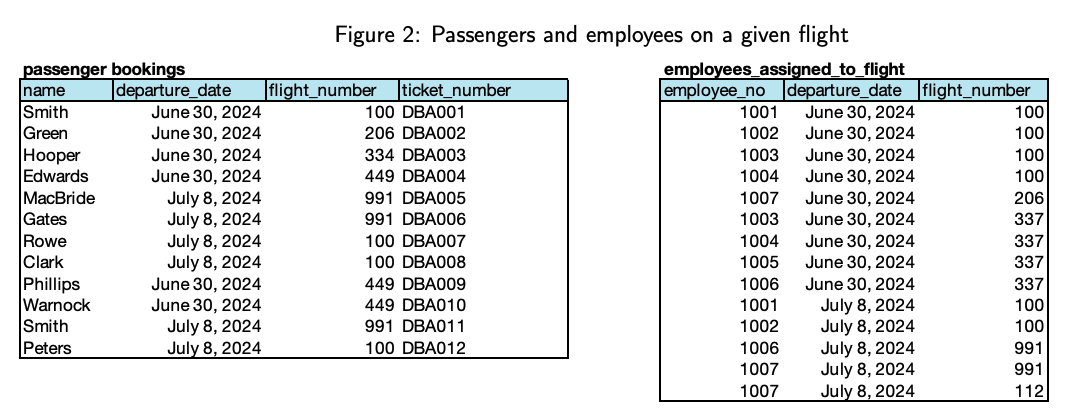

In [9]:
try:
    conn = mysql.connector.connect(
        database='db_airways',
        user='admin',
        password='oreois15',
        host='bankdb.cxhkqfq4ih8i.us-east-1.rds.amazonaws.com'
    )
    
    cursor = conn.cursor()
    
    passenger_records = [
        ('DBA001', 'Smith'),
        ('DBA002', 'Green'),
        ('DBA003', 'Hooper'),
        ('DBA004', 'Edwards'),
        ('DBA005', 'MacBride'),
        ('DBA006', 'Gates'),
        ('DBA007', 'Rowe'),
        ('DBA008', 'Clark'),
        ('DBA009', 'Phillips'),
        ('DBA010', 'Warnock'),
        ('DBA011', 'Smith'),
        ('DBA012', 'Peters')
    ]
    
    booked_on_records = [
        ('DBA001', '2024-06-30', 100),
        ('DBA002', '2024-06-30', 206),
        ('DBA003', '2024-06-30', 334),
        ('DBA004', '2024-06-30', 449),
        ('DBA005', '2024-07-08', 991),
        ('DBA006', '2024-07-08', 991),
        ('DBA007', '2024-07-08', 100),
        ('DBA008', '2024-07-08', 100),
        ('DBA009', '2024-06-30', 449),
        ('DBA010', '2024-06-30', 449),
        ('DBA011', '2024-07-08', 991),
        ('DBA012', '2024-07-08', 100)
    ]
    
    assigned_to_records = [
        (1001, '2024-06-30', 100),
        (1002, '2024-06-30', 100),
        (1003, '2024-06-30', 100),
        (1004, '2024-06-30', 100),
        (1007, '2024-06-30', 206),
        (1003, '2024-06-30', 337),
        (1005, '2024-06-30', 337),
        (1006, '2024-06-30', 337),
        (1001, '2024-07-08', 100),
        (1002, '2024-07-08', 100),
        (1006, '2024-07-08', 991),
        (1007, '2024-07-08', 991),
        (1007, '2024-07-08', 112)
    ]
    
    cursor.executemany(
        """
        INSERT INTO passenger (ticket_number, name) VALUES (%s, %s)
        """, 
        passenger_records
    )
    
    cursor.executemany(
        """
        INSERT INTO booked_on (ticket_number, departure_date, flight_number) VALUES (%s, %s, %s)
        """,
        booked_on_records
    )
    
    cursor.executemany(
        """
        INSERT INTO assigned_to (employee_no, departure_date, flight_number) VALUES (%s, %s, %s)
        """,
        assigned_to_records
    )
    
    conn.commit()
    print(f"{len(passenger_records)} record(s) inserted into the passenger table")
    print(f"{len(booked_on_records)} record(s) inserted into the booked_on table")
    print(f"{len(assigned_to_records)} record(s) inserted into the assigned_to table")
        
except mysql.connector.Error as error:
    print(f"Error: {error}")
    conn.rollback()

finally:
    conn.close()

12 record(s) inserted into the passenger table
12 record(s) inserted into the booked_on table
13 record(s) inserted into the assigned_to table


## Question 1 (c)

Write a single query that returns a list of all passengers on flight 991. By single query we mean making
a single trip to the database. Include the following fields in your result: passenger_name, ticket_number,
address, phone

In [10]:
conn = mysql.connector.connect(
    database='db_airways',
    user='admin',
    password='oreois15',
    host='bankdb.cxhkqfq4ih8i.us-east-1.rds.amazonaws.com'
)

cursor = conn.cursor()

query = """
    SELECT
        per.name AS passenger_name,
        pas.ticket_number,
        per.address,
        per.phone
    FROM
        booked_on b
    INNER JOIN
        passenger pas ON b.ticket_number = pas.ticket_number
    INNER JOIN
        person per ON pas.name = per.name
    WHERE
        b.flight_number = 991;
    """

cursor.execute(query)

results = cursor.fetchall()

heading = ["Passenger Name", "Ticket Number", "Address", "Phone"]
column_widths = [20, 20, 20, 19]

print(f'| {heading[0]:<20} | {heading[1]:<20} | {heading[2]:<20} | {heading[3]:<15} |')
print('-' * (sum(column_widths) + (len(heading) - 1) * 3))

for row in results:
    print(
        f'| {row[0]:<20} | '
        f'{row[1]:<20} | '
        f'{row[2]:<20} | '
        f'{row[3]:<15} |'
    )
    
cursor.close()
conn.close()

| Passenger Name       | Ticket Number        | Address              | Phone           |
----------------------------------------------------------------------------------------
| MacBride             | DBA005               | 789 Fir St.          | null            |
| Gates                | DBA006               | 285 Kapok St.        | 801-493-2203    |
| Smith                | DBA011               | 123 Elm St.          | 801-556-2239    |


## Question 1 (d)

Imagine that the airline would like to implement a trigger named emergency that sets a flight status
to “canceled” when there is an emergency and the departure date for a flight has been changed to a later date.
Now, suppose a hurricane has been forecasted for July 8, 2024 and the company would like to change the
departure date for all flights booked for July 8, 2024 to July 15, 2024. Create and test a trigger that makes
the necessary changes. To test the trigger, issue an SQL statement to change all flights scheduled to depart on
July 8, 2024 to a new departure date of July 15, 2024. Then print out the data in your flight table to show the
cancellations.

In [11]:
conn = mysql.connector.connect(
    database='db_airways',
    user='admin',
    password='oreois15',
    host='bankdb.cxhkqfq4ih8i.us-east-1.rds.amazonaws.com'
)

cursor = conn.cursor()

cursor.execute("DROP TRIGGER IF EXISTS emergency")

trigger = """
CREATE TRIGGER emergency AFTER UPDATE ON departure FOR EACH ROW
BEGIN
    IF OLD.departure_date = '2024-07-08' AND NEW.departure_date = '2024-07-15' THEN
        UPDATE flight
        SET status = 'canceled'
        WHERE flight_number = OLD.flight_number;

        UPDATE assigned_to
        SET departure_date = NEW.departure_date
        WHERE departure_date = OLD.departure_date AND flight_number = OLD.flight_number;

        UPDATE booked_on
        SET departure_date = NEW.departure_date
        WHERE departure_date = OLD.departure_date AND flight_number = OLD.flight_number;
    END IF;
END;
"""

try:
    cursor.execute(trigger)
    conn.commit()
    print("Trigger created successfully.")
except mysql.connector.Error as err:
    print(f"Error creating trigger: {err}")

test_update = """
    UPDATE departure
    SET departure_date = '2024-07-15'
    WHERE departure_date = '2024-07-08';
"""

try:
    cursor.execute(test_update)
    conn.commit()
    print("Test update executed successfully.\n")
except mysql.connector.Error as err:
    print(f"Error updating departure date: {err}")

try:
    cursor.execute("SELECT * FROM departure WHERE departure_date = '2024-07-15'")
    results = cursor.fetchall()

    if results:
        for row in results:
            print(f'Flight {row[1]} has been canceled and rescheduled to {row[0]}')
    else:
        print("No records found with the updated departure date.")
except mysql.connector.Error as err:
    print(f"Error fetching flight data: {err}")

cursor.close()
conn.close()

Trigger created successfully.
Test update executed successfully.

Flight 100 has been canceled and rescheduled to 2024-07-15
Flight 112 has been canceled and rescheduled to 2024-07-15
Flight 206 has been canceled and rescheduled to 2024-07-15
Flight 334 has been canceled and rescheduled to 2024-07-15
Flight 395 has been canceled and rescheduled to 2024-07-15
Flight 991 has been canceled and rescheduled to 2024-07-15


## Question 1 (e)

It has been estimated that airline pilots fly an average of 75 hours per month. Write a procedure
named “estimate_pilot_years” that accepts a pilot’s employee ID and returns the number of years the pilot has
been flying based on their flight hours in the database. (Assume the pilots at DB Airways work for 12 months per
year. Do not worry about overtime, breaks, or any other complicating factor). Test your procedure by returning
the estimated years for all pilots in the database.

In [12]:
try:
    conn = mysql.connector.connect(
        database='db_airways',
        user='admin',
        password='oreois15',
        host='bankdb.cxhkqfq4ih8i.us-east-1.rds.amazonaws.com'
    )

    cursor = conn.cursor()
    
    procedure_creation_query = """
    CREATE PROCEDURE estimate_pilot_years(IN pilot_id INT, OUT years DECIMAL(10,2))
    BEGIN
        DECLARE totalFlightHours INT;
        DECLARE average_monthly_hours INT DEFAULT 75;
        DECLARE month_per_year INT DEFAULT 12;

        SELECT flight_hours INTO totalFlightHours
        FROM pilot
        WHERE employee_no = pilot_id;

        SET years = totalFlightHours / (average_monthly_hours * month_per_year); 
    END;
    """
    cursor.execute("DROP PROCEDURE IF EXISTS estimate_pilot_years")
    cursor.execute(procedure_creation_query)

    # Retrieve all employee IDs
    cursor.execute("SELECT employee_no FROM pilot")
    employee_ids = cursor.fetchall()
    
    for (emp_id,) in employee_ids:
        # Fetch the flight hours directly for debugging
        args = (emp_id, 0)
        test = cursor.callproc('estimate_pilot_years', args)
        
        print(f'Employee ID: {emp_id}, Estimated Years: {test[1]}')

        
except Error as e:
    print(e)
finally:
    if cursor:
        cursor.close()
    if conn:
        conn.close()

Employee ID: 1001, Estimated Years: 6.67
Employee ID: 1002, Estimated Years: 26.67
Employee ID: 1003, Estimated Years: 16.67
